<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/VisualizationsNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploring Normalization Strategies for SVM for Single Subject Brain State Prediction
##Creating Summary Statistics and Visualization for the Normalization Strategies
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
-This notebook runs summary statistics and visualizations from stored data.


> Explores three normalization strategies on time series fMRI data that is already detrended: percent signal change(psc), z-score normalization(zscore), and no normalization(nonorm).


> First, explore boxplots of the three strategies and create summary statistics of all individual models. Creates boxplots for all models, adolescents, and young adults.


> Second, explore cross validation results of best normalization this is across all models.


> Third, create beta-maps which highlights voxels of interest for both increase and decrease timepoints.


> Fourth, look at decision function scores for example young adult and example adolescent











In [216]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [217]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [218]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls

Cloning into 'teambrainiac'...
remote: Enumerating objects: 1756, done.
remote: Counting objects: 100% (1756/1756), done.
remote: Compressing objects: 100% (1392/1392), done.
remote: Total 1756 (delta 1139), reused 689 (delta 347), pack-reused 0
Receiving objects: 100% (1756/1756), 92.44 MiB | 24.69 MiB/s, done.
Resolving deltas: 100% (1139/1139), done.
/content/teambrainiac/source/teambrainiac/source
access_data.py			    process.py
brain_viz_single_subj.py	    single_subject.py
BuildSingleSubjectSVM_Models.ipynb  SingleSubjectSVM.ipynb
data				    streamlit
DL				    utils.py
group_svm			    VisualizationPlayground.ipynb
helper				    VisualizationsNotebook.ipynb
__init__.py


In [219]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


In [220]:
# Import libraries
!pip install boto3 nilearn nibabel
#to load data
import pickle
#common packages we need
import numpy as np
import pandas as pd
#for brain imaging
import nibabel as nib
from nilearn import plotting, image
#for making graphs
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline
import seaborn as sns
from nilearn.image import threshold_img
#sklearn packages needed
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
#import code for processing and visualizing data
from single_subject import *
from access_data import *
from brain_viz_single_subj import *

#####Get Common Variables we need for Notebook

In [221]:
#get common variables we need across multiple cells
data_path_dict = get_data_dict()
subj_ids, _ = get_subj_information(data_path_dict)
_ , y_test,_= get_labels(data_path_dict)
##get brain images
affine_image,t1_image,mni_image = get_brain_templates()

###Explore Normalization Approaches

In [222]:
##load normalization results
norm_results_df = pd.read_csv('/content/drive/My Drive/data/dataexploration/rbf_exploration/accuracy_results.csv')
#load normalization models
subject_models = open_pickle('/content/drive/My Drive/data/dataexploration/rbf_exploration/norm_models.pkl')
##clean up df
norm_results_df.drop(columns=['Unnamed: 0'],inplace=True)

####Creating Summary Statistics

In [223]:

adol_final_df = norm_results_df.iloc[0:33,:] #get adolescent data
ya_final_df = norm_results_df.iloc[33:,:] #get young adult data

##create summary statistics for the three df (all,adolescent,young adult)
##all 52 subjects
stats_norm_all = norm_results_df.groupby(['norm_type']).mean()
stats_norm_all.reset_index(inplace=True) #reset index

print('Summary Statistics for All 52 subjects')
print(stats_norm_all)
print("")
##adolescent
stats_norm_adol = adol_final_df.groupby(['norm_type']).mean()
stats_norm_adol.reset_index(inplace=True) #reset index
 ##save to csv
print('Summary Statistics for 32 adolescent subjects')
print(stats_norm_adol)
print("")
##young adult
stats_norm_ya = ya_final_df.groupby(['norm_type']).mean()
stats_norm_ya.reset_index(inplace=True) #reset index
print('Summary Statistics for 19 young adult subjects')
print(stats_norm_ya)
print("")
##uncomment to save results
stats_norm_all.to_csv('/content/drive/My Drive/data/dataexploration/rbf_exploration/all_final_summary_normalizations.csv') ##save to csv
stats_norm_adol.to_csv('/content/drive/My Drive/data/dataexploration/rbf_exploration/adol_final_summary_normalizations.csv') ##save to csv
stats_norm_ya.to_csv('/content/drive/My Drive/data/dataexploration/rbf_exploration/ya_final_summary_normalizations.csv') ##save to csv

Summary Statistics for All 52 subjects
  norm_type  train_acc  run_03_acc  run_03_f1_score  run_04_acc  \
0      none   0.970467    0.673764         0.675575    0.625458   
1       psc   0.814103    0.562729         0.496667    0.543727   
2    zscore   0.992674    0.734432         0.722243    0.649038   

   run_04_f1_score  
0         0.613556  
1         0.505227  
2         0.631844  

Summary Statistics for 32 adolescent subjects
  norm_type  train_acc  run_03_acc  run_03_f1_score  run_04_acc  \
0      none   0.971861    0.635281         0.608811    0.668831   
1       psc   0.801948    0.555195         0.503907    0.600649   
2    zscore   0.992424    0.721861         0.708382    0.694805   

   run_04_f1_score  
0         0.597847  
1         0.517618  
2         0.673162  

Summary Statistics for 19 young adult subjects
  norm_type  train_acc  run_03_acc  run_03_f1_score  run_04_acc  \
0      none   0.970093    0.684088         0.693488    0.613821   
1       psc   0.817364    

####Get Boxplots


---


We do this to show the spread across the subjects.
As the visualization shows there is quite a difference between subjects. This 
is to be expected as individuals differ in how well they may regulate. You can also see from the charts and above statistics that normalizing the data by z normalization gives us the best accuracy results.

Run 03 gives better results and this makes sense because run 03 is a feedback run where the participants are being told how well the are regulating the NAcc. In run_04, they are not given any feedback.

Adolescents and young adults are pretty similar in their predictions for z-score, but if we look at the data that doesn't have any normalization performed, we can see that the young adults out perform the adolescents quite a bit.

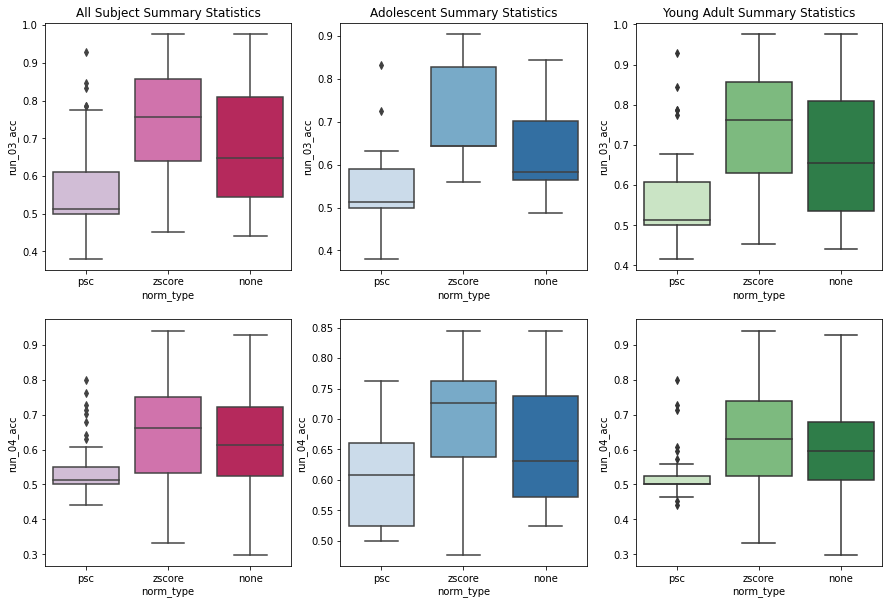

In [224]:
##create box plots accross all subjects
fig,axes=plt.subplots(2,3,figsize=(15,10)) #get figure size
sns.boxplot(x='norm_type',y='run_03_acc',data=norm_results_df, ax=axes[0,0],palette='PuRd')
sns.boxplot(x='norm_type',y='run_04_acc',data=norm_results_df, ax=axes[1,0],palette='PuRd')  
axes[0,0].set_title('All Subject Summary Statistics')

##create box plots for adolescent
sns.boxplot(x='norm_type',y='run_03_acc',data=adol_final_df, ax=axes[0,1],palette='Blues') #plot val scroes
sns.boxplot(x='norm_type',y='run_04_acc',data=adol_final_df, ax=axes[1,1],palette='Blues')  #plot test scores
axes[0,1].set_title('Adolescent Summary Statistics')

##create box plots for ya
sns.boxplot(x='norm_type',y='run_03_acc',data=ya_final_df, ax=axes[0,2],palette='Greens') #plot val scroes
sns.boxplot(x='norm_type',y='run_04_acc',data=ya_final_df, ax=axes[1,2],palette='Greens')  #plot test scores
axes[0,2].set_title('Young Adult Summary Statistics')
##uncomment to save results
fig.savefig('/content/drive/My Drive/data/dataexploration/rbf_exploration/normalization_boxplot.png',dpi=200)
plt.show()


###Cross-Validation

####Create Summary Statistics DataFrame and Boxplot Visualization

In [227]:
##load cross validation results
##this will take a while to load
cv_results = open_pickle('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_short/cv_results.pkl')

                 Cross Validation Parameters      
mean_test_score  Kernel: RBF C: 1 Gamma: 0.0001       0.574569
                 Kernel: RBF C: 1 Gamma: 0.01         0.568559
                 Kernel: RBF C: 1 Gamma: auto         0.693503
                 Kernel: RBF C: 1 Gamma: scale        0.693616
                 Kernel: RBF C: 10 Gamma: 0.0001      0.576612
                 Kernel: RBF C: 10 Gamma: 0.01        0.568559
                 Kernel: RBF C: 10 Gamma: auto        0.691396
                 Kernel: RBF C: 10 Gamma: scale       0.691297
                 Kernel: RBF C: 1000 Gamma: 0.0001    0.576612
                 Kernel: RBF C: 1000 Gamma: 0.01      0.568559
                 Kernel: RBF C: 1000 Gamma: auto      0.691396
                 Kernel: RBF C: 1000 Gamma: scale     0.691297
                 Kernel: RBF C: 5 Gamma: 0.0001       0.576612
                 Kernel: RBF C: 5 Gamma: 0.01         0.568559
                 Kernel: RBF C: 5 Gamma: auto         0.691396
    

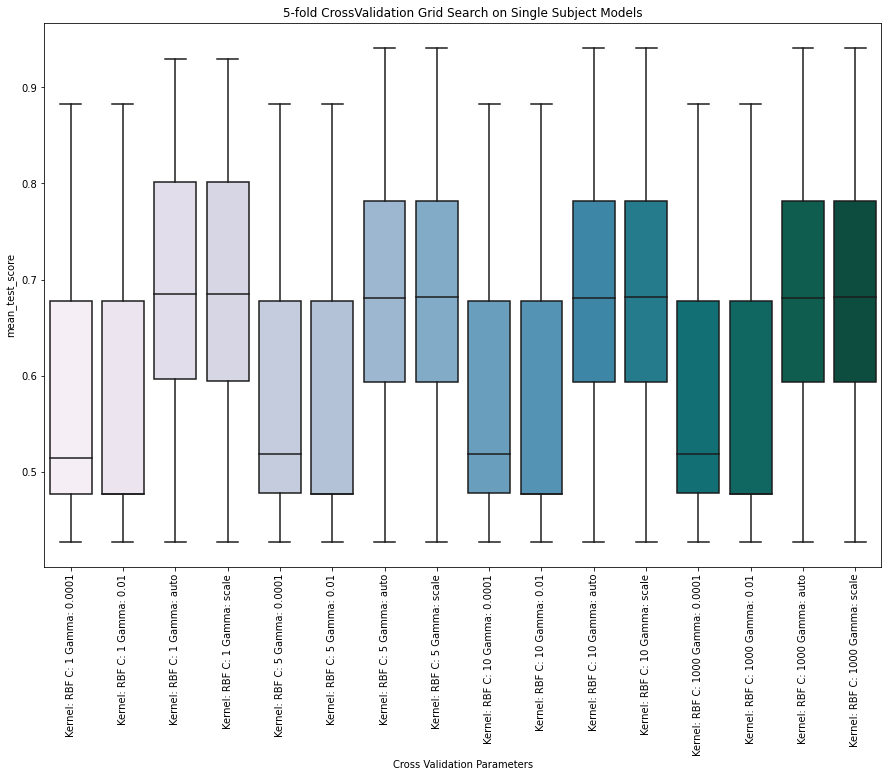

In [229]:
###cell to look at cross validation results on run 2 over all subjects
#create for loop to create summary df of cross validation results using decision function ovr
final_df = pd.DataFrame() #initialize df
#loop over subjects
for sub_id in subj_ids:
  model = cv_results[sub_id]['model'] #load model from dictionary
  model.cv_results_ #get cv_results
  model_df = pd.DataFrame(model.cv_results_) #convert to dataframe
  model_df['subject'] = sub_id #add subject id column
  sub_df = model_df[['subject','param_C', 'param_gamma','mean_test_score','std_test_score']] #grab columns of interest
  #create df
  if len(final_df)==0:
    final_df = sub_df
  else:
    final_df = pd.concat([final_df,sub_df])

#get summary statistics for cross validation
stats_df = final_df.groupby(['param_C','param_gamma']).agg({'mean_test_score': ['mean','std']})
##add column to condense param_c and param_kernel for plotting purposes
final_df['Cross Validation Parameters'] = "Kernel: RBF" + " C: " + final_df['param_C'].astype(str) + " Gamma: " + final_df['param_gamma'].astype(str)
#create a sub_df for graph
cv_results_graph_df = final_df[['subject','Cross Validation Parameters','mean_test_score',]]
#create a df to export for summary statistics in excel
final_df_wide = pd.pivot_table(cv_results_graph_df,index = ['subject'],columns=['Cross Validation Parameters'],values=['mean_test_score'])
final_df_summary = final_df_wide.mean() ##get mean across rows
print(final_df_summary)
##save results
final_df_wide.to_csv('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results.csv')

##plot cross validation results
fig,axes=plt.subplots(1,figsize=(15,10))
# plt.figure(figsize=(30,10))
plt.title('5-fold CrossValidation Grid Search on Single Subject Models')
sns.boxplot(x='Cross Validation Parameters',y='mean_test_score',data=cv_results_graph_df,palette="PuBuGn",ax=axes)
plt.xticks(rotation=90)
#save figure
plt.savefig('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_tr_2_te_3_4.png',dpi=200)
plt.show()


In [230]:
##load cross validation results
##this will take a while to load
cv_results = open_pickle('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_short/cv_results_short.pkl')

                 Cross Validation Parameters     
mean_test_score  Kernel: RBF C: 1 Gamma: auto        0.726357
                 Kernel: RBF C: 1 Gamma: scale       0.726584
                 Kernel: RBF C: 10 Gamma: auto       0.722144
                 Kernel: RBF C: 10 Gamma: scale      0.721946
                 Kernel: RBF C: 1000 Gamma: auto     0.722144
                 Kernel: RBF C: 1000 Gamma: scale    0.721946
                 Kernel: RBF C: 5 Gamma: auto        0.722144
                 Kernel: RBF C: 5 Gamma: scale       0.721946
dtype: float64


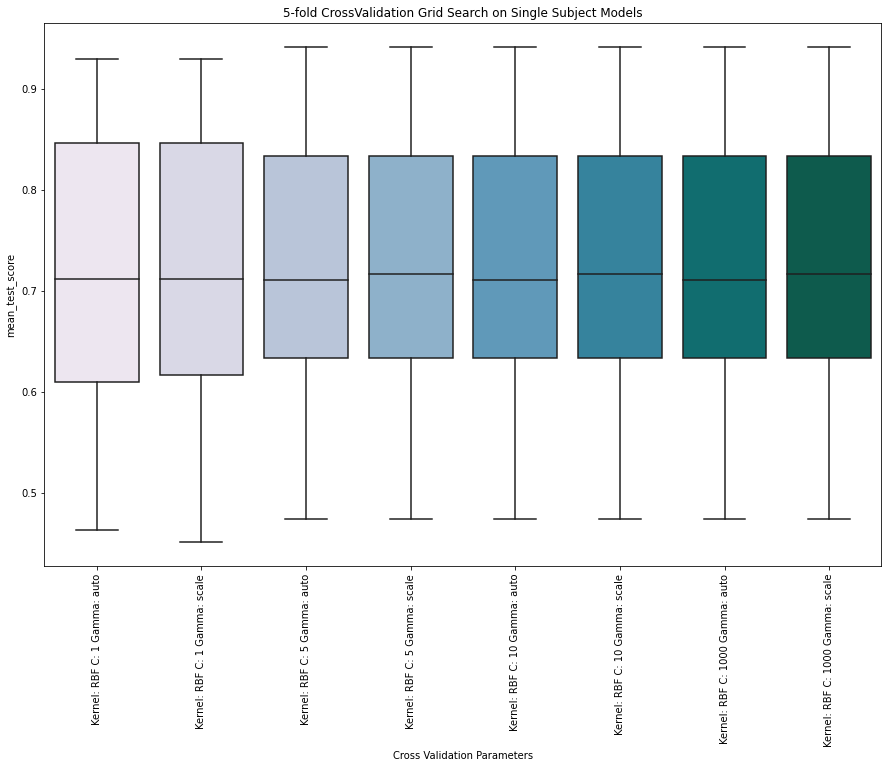

In [231]:
###cell to look at cross validation results on run 2 over all subjects
#create for loop to create summary df of cross validation results using decision function ovr
final_df = pd.DataFrame() #initialize df
#loop over subjects
for sub_id in subj_ids:
  model = cv_results[sub_id]['model'] #load model from dictionary
  model.cv_results_ #get cv_results
  model_df = pd.DataFrame(model.cv_results_) #convert to dataframe
  model_df['subject'] = sub_id #add subject id column
  sub_df = model_df[['subject','param_C', 'param_gamma','mean_test_score','std_test_score']] #grab columns of interest
  #create df
  if len(final_df)==0:
    final_df = sub_df
  else:
    final_df = pd.concat([final_df,sub_df])

#get summary statistics for cross validation
stats_df = final_df.groupby(['param_C','param_gamma']).agg({'mean_test_score': ['mean','std']})
##add column to condense param_c and param_kernel for plotting purposes
final_df['Cross Validation Parameters'] = "Kernel: RBF" + " C: " + final_df['param_C'].astype(str) + " Gamma: " + final_df['param_gamma'].astype(str)
#create a sub_df for graph
cv_results_graph_df = final_df[['subject','Cross Validation Parameters','mean_test_score',]]
#create a df to export for summary statistics in excel
final_df_wide = pd.pivot_table(cv_results_graph_df,index = ['subject'],columns=['Cross Validation Parameters'],values=['mean_test_score'])
final_df_summary = final_df_wide.mean() ##get mean across rows
print(final_df_summary)
##save results
final_df_wide.to_csv('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_short.csv')

##plot cross validation results
fig,axes=plt.subplots(1,figsize=(15,10))
# plt.figure(figsize=(30,10))
plt.title('5-fold CrossValidation Grid Search on Single Subject Models')
sns.boxplot(x='Cross Validation Parameters',y='mean_test_score',data=cv_results_graph_df,palette="PuBuGn",ax=axes)
plt.xticks(rotation=90)
#save figure
plt.savefig('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_tr_2_te_3_4_short.png',dpi=200)
plt.show()


In [232]:
##load cross validation results
##this will take a while to load
cv_results = open_pickle('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_short.pkl')

                 Cross Validation Parameters     
mean_test_score  Kernel: RBF C: 1 Gamma: auto        0.731870
                 Kernel: RBF C: 1 Gamma: scale       0.731979
                 Kernel: RBF C: 10 Gamma: auto       0.733015
                 Kernel: RBF C: 10 Gamma: scale      0.733464
                 Kernel: RBF C: 1000 Gamma: auto     0.733015
                 Kernel: RBF C: 1000 Gamma: scale    0.733464
                 Kernel: RBF C: 5 Gamma: auto        0.733015
                 Kernel: RBF C: 5 Gamma: scale       0.733464
dtype: float64


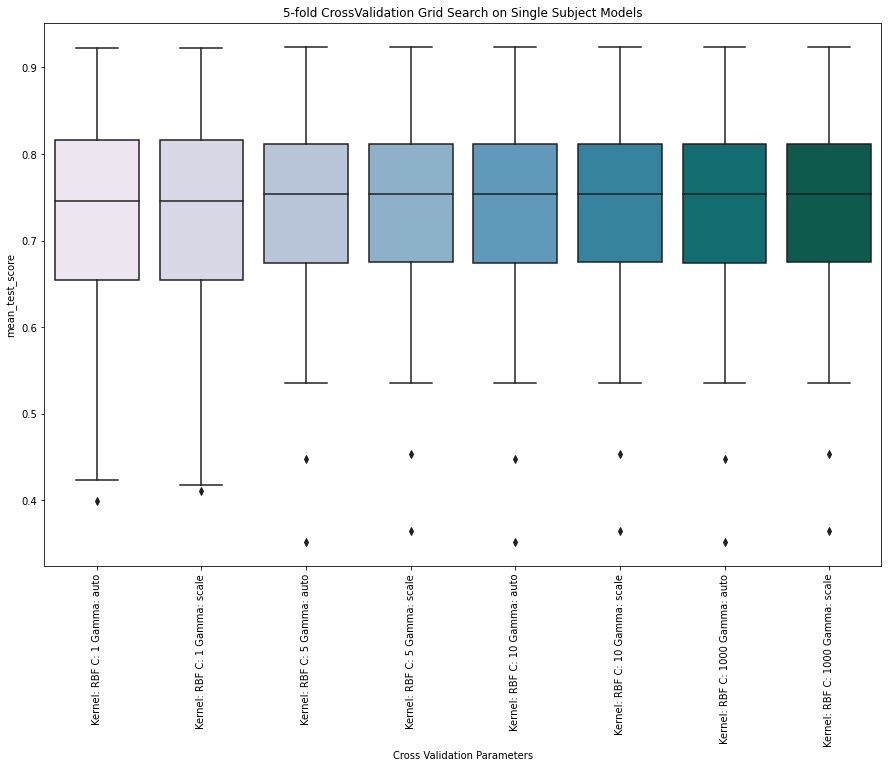

In [233]:
###cell to look at cross validation results on run 2 over all subjects
#create for loop to create summary df of cross validation results using decision function ovr
final_df = pd.DataFrame() #initialize df
#loop over subjects
for sub_id in subj_ids:
  model = cv_results[sub_id]['model'] #load model from dictionary
  model.cv_results_ #get cv_results
  model_df = pd.DataFrame(model.cv_results_) #convert to dataframe
  model_df['subject'] = sub_id #add subject id column
  sub_df = model_df[['subject','param_C', 'param_gamma','mean_test_score','std_test_score']] #grab columns of interest
  #create df
  if len(final_df)==0:
    final_df = sub_df
  else:
    final_df = pd.concat([final_df,sub_df])

#get summary statistics for cross validation
stats_df = final_df.groupby(['param_C','param_gamma']).agg({'mean_test_score': ['mean','std']})
##add column to condense param_c and param_kernel for plotting purposes
final_df['Cross Validation Parameters'] = "Kernel: RBF" + " C: " + final_df['param_C'].astype(str) + " Gamma: " + final_df['param_gamma'].astype(str)
#create a sub_df for graph
cv_results_graph_df = final_df[['subject','Cross Validation Parameters','mean_test_score',]]
#create a df to export for summary statistics in excel
final_df_wide = pd.pivot_table(cv_results_graph_df,index = ['subject'],columns=['Cross Validation Parameters'],values=['mean_test_score'])
final_df_summary = final_df_wide.mean() ##get mean across rows
print(final_df_summary)
##save results
final_df_wide.to_csv('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_short.csv')

##plot cross validation results
fig,axes=plt.subplots(1,figsize=(15,10))
# plt.figure(figsize=(30,10))
plt.title('5-fold CrossValidation Grid Search on Single Subject Models')
sns.boxplot(x='Cross Validation Parameters',y='mean_test_score',data=cv_results_graph_df,palette="PuBuGn",ax=axes)
plt.xticks(rotation=90)
#save figure
plt.savefig('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_tr_1_2_te_3_4_short.png',dpi=200)
plt.show()

####Visualize Normalization Strategies

#####Brain Visualizations

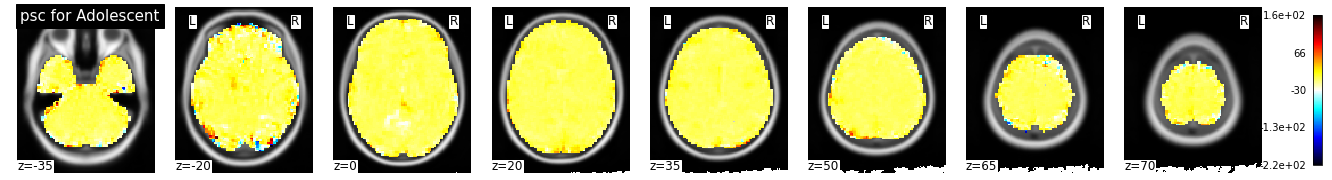

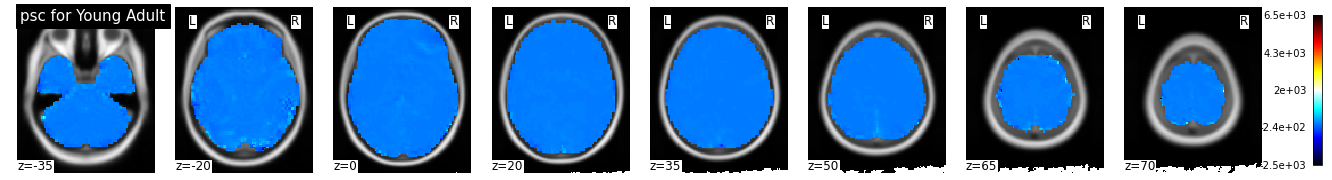

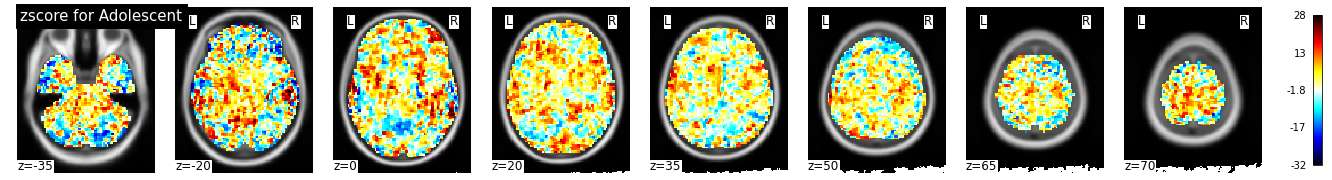

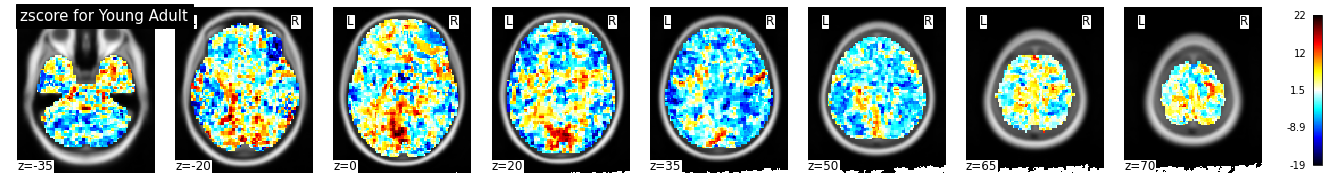

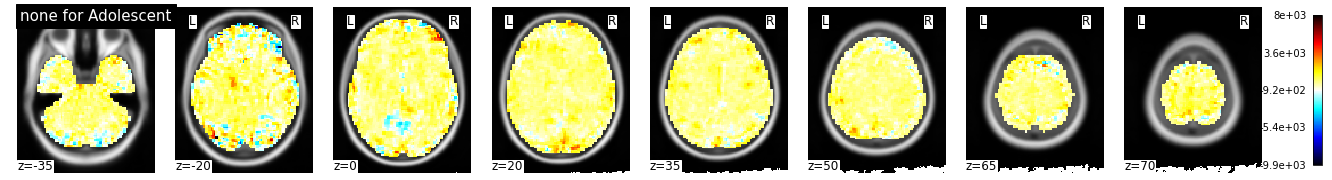

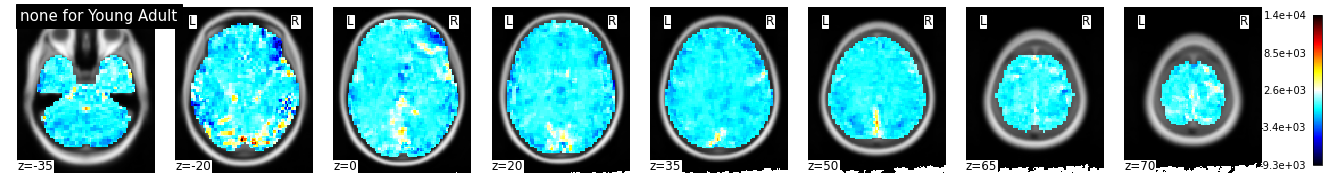

In [241]:
#cell for displaying data
outf_path = None #change to path name if want to say images. Just need path (filename appended in function call)
subject_types = ['Adolescent','Young Adult'] ##which group it belongs too
mask_data = get_mask_data(data_path_dict,0) #grab indices of mask to use
_,ind = make_mask(mask_data['mask']) #make mask (flatten to 1-d array of boolean values FALSE=NOT PART OF BRAIN, TRUE=BRAIN)
#iterate over norm types
for norm_type in list(subject_models.keys()):
  norm_models = subject_models[norm_type]
  subj_list = list(norm_models.keys())
  for idx in range(len(subj_list)):
    subj_id = subj_list[idx]
    subj_data = norm_models[subj_id]
    bmap3=None #set bmap3 to none (nilearn is fickle)
    disp_image=None #set disp image to none (nilearn is fickle)
    #get subject model dictionary
    _,bmap3_nii = create_bmaps(subj_data,ind,affine_image) #grab bmap3 (nifti)
    plot_map(bmap3_nii,norm_type,subject_types[idx],out_fname=outf_path,threshold=.0001,t_image=mni_image) #get image

#####Decision Function Plots
* These plots show the score of the timepoints and how the svm will predict. Above 0  = increase brain state, below zero = decrease brain state. We can see through this how well the model is predicting at each time point.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


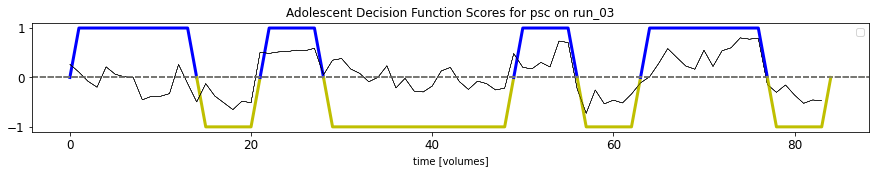

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


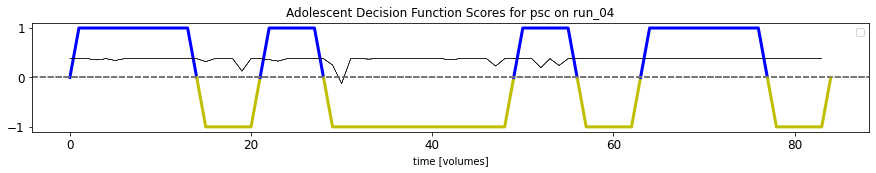

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


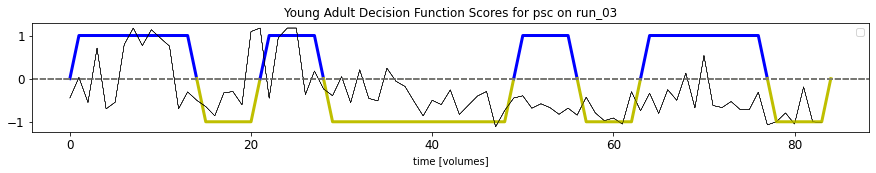

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


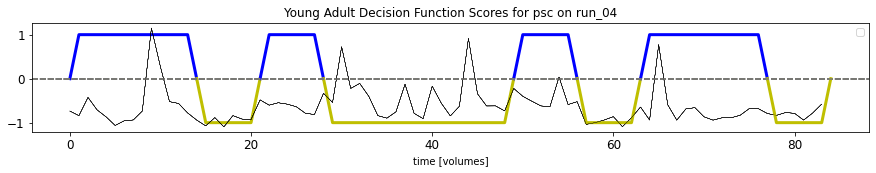

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


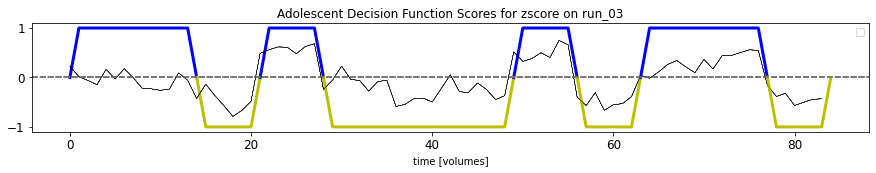

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


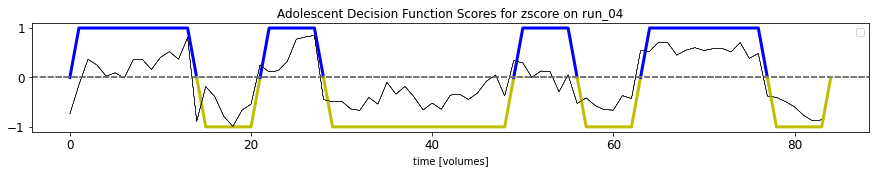

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


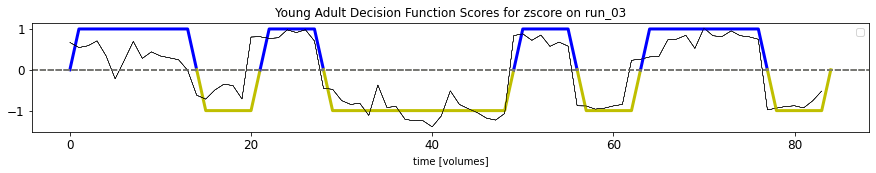

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


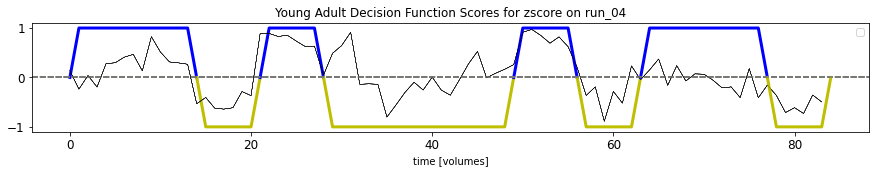

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


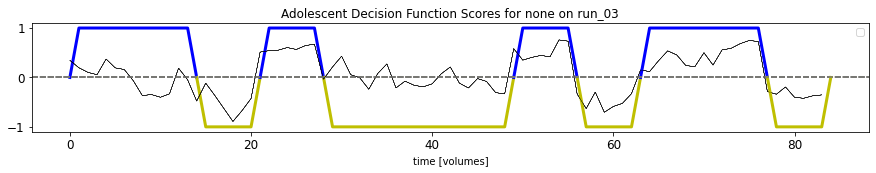

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


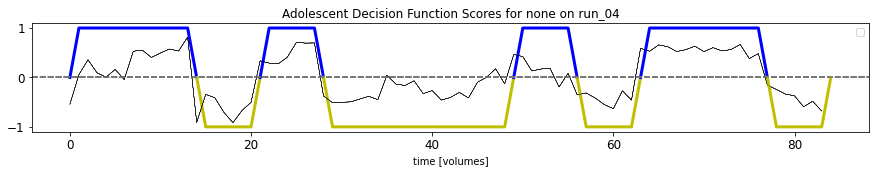

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


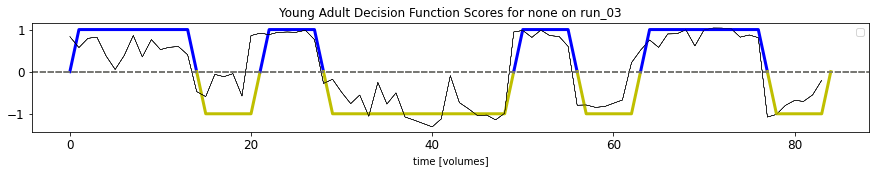

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


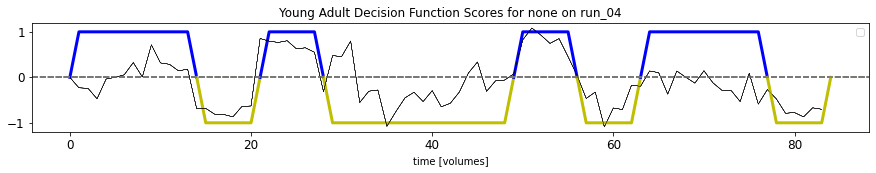

In [235]:
subject_types = ['Adolescent','Young Adult'] ##which group it belongs too
runs_test = ['run_03','run_04'] ##which runs do we want to test on
outf_path = '/content/drive/My Drive/data/dataexploration/rbf_exploration/'
for norm_type in list(subject_models.keys()): #iterate over norm types
  norm_models = subject_models[norm_type] #get normtype subject models
  subj_list = list(norm_models.keys()) #grab subject ids
  #iterate over subjects
  for idx in range(len(subj_list)):
    subj_id = subj_list[idx] #subjectid
    subj_data = norm_models[subj_id] #get subject data
    #get predictions returns subject predictions from clf
    subj_predicts = get_predicts(subj_data['model'],subj_data['data'],runs_test)
    #iterate over runs to display
    for run in runs_test:
      decf_scores = subj_predicts[run]['decision_function'] #get decision score
      decision_function_labels = np.where(subj_data['y_test']==0,-1,1) #put scores in range of -1, 1 to match svm outputs
      plot_decision_scores(decf_scores,decision_function_labels,norm_type,subject_types[idx],run,outf_path)


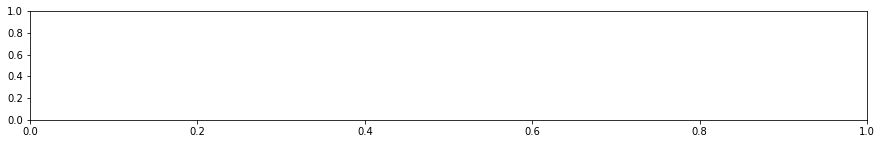

In [236]:

x = [0]
y = [0]
decision_function_labels = np.where(subj_data['y_test']==0,-1,1) #put scores in range of -1, 1 to match svm outputs
decf_labels = np.append(decision_function_labels,0)
fig, ax = plt.subplots(1,1,figsize=(15, 2))

for tp in range(1,85): 
    if decf_labels[tp-1] == decf_labels[tp]:
      x.append(tp)
      y.append(decf_labels[tp])
    else:
      y.append(0)
      x.append(tp)
      if y[1] == 1:
        color = 'b'
      else: 
        color='y'      
      # ax.plot(x,y,c=color,lw=3)
      # ax.axhline(y=0,c='#787874',linestyle='--')
      y=[0]
      x=[tp]
      # ax.plot(decf_scores,c='k',lw=0.2,linestyle='-')
      # ax.legend(['Increase','Decision Function Cutoff','Decision Scores','Decrease'],bbox_to_anchor=(1,1.04), loc="upper left")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
fig = plt.figure()
fig.add_artist(lines.Line2D([0, 1], [0, 1]))
fig.add_artist(lines.Line2D([0, 1], [1, 0]))
plt.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
decf_scores_df = pd.DataFrame(decf_scores,columns=['decf_scores'])
decf_scores_df['TimePoint'] = range(1,85)
decf_scores_df

,decf_scores,TimePoint
0,-0.001181,1
1,-0.231405,2
2,-0.240909,3
3,-0.472055,4
4,-0.038310,5
...,...,...
79,-0.789257,80
80,-0.776105,81
81,-0.869522,82
82,-0.670869,83


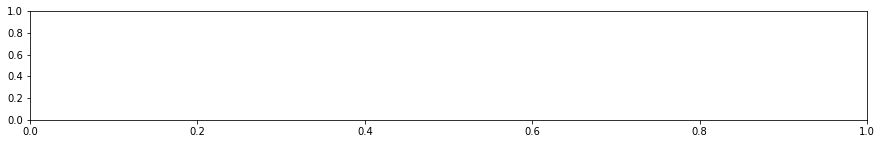

In [237]:
import altair as alt
x = [0]
y = [0]
test_df = []
test_df.append(['Increase_1',0,0,'Increase','blue'])
decision_function_labels = np.where(subj_data['y_test']==0,-1,1) #put scores in range of -1, 1 to match svm outputs
decf_labels = np.append(decision_function_labels,0)
fig, ax = plt.subplots(1,1,figsize=(15, 2))
increase_count = 1
decrease_count = 1
inc_str = 'Increase_1'
dec_str = 'Decrease_1'
for tp in range(1,85): 
    if decf_labels[tp-1] == decf_labels[tp]:
    
      if decf_labels[tp] == 1:
        x_y = [inc_str,tp,decf_labels[tp],'Increase','blue']
      else:
        x_y = [dec_str,tp,decf_labels[tp],'Decrease','yellow']
      test_df.append(x_y)
    else:
      if decf_labels[tp-1] == 1:

        #x_y = [inc_str,tp,'blue']
        x_y = [inc_str,tp-1,1,'Increase','blue']
        test_df.append(x_y)
        x_y = [inc_str,tp,0,'Increase','blue']
        test_df.append(x_y)
        x_y = [dec_str,tp,0,'Decrease','yellow']
        test_df.append(x_y)
        increase_count += 1
        inc_str = 'Increase_' + str(increase_count)
      else: 
        x_y = [dec_str,tp-1,-1,'Decrease','yellow']
        test_df.append(x_y)
        x_y = [dec_str,tp,0,'Decrease','yellow']
        test_df.append(x_y)
        x_y = [inc_str,tp,0,'Increase','blue']
        test_df.append(x_y)
        decrease_count += 1
        dec_str = 'Decrease_' + str(decrease_count)

In [238]:
viz_df = pd.DataFrame(test_df,columns=['BlockType','Timepoint','Value','Block','Color'])
viz_df

,BlockType,Timepoint,Value,Block,Color
0,Increase_1,0,0,Increase,blue
1,Increase_1,1,1,Increase,blue
2,Increase_1,2,1,Increase,blue
3,Increase_1,3,1,Increase,blue
4,Increase_1,4,1,Increase,blue
...,...,...,...,...,...
96,Decrease_4,82,-1,Decrease,yellow
97,Decrease_4,83,-1,Decrease,yellow
98,Decrease_4,83,-1,Decrease,yellow
99,Decrease_4,84,0,Decrease,yellow


In [239]:
chart_final = alt.Chart().mark_line().encode(

)
for block_type in viz_df.BlockType.unique():
  df = viz_df[viz_df['BlockType']==block_type]
  line_color = df.iloc[0,4]
  print(line_color)
  chart_test = alt.Chart(df).mark_line(color=line_color).encode(
      x = alt.X('Timepoint:N',title='Time Point'),
      y= alt.Y('Value:Q'),
      color=alt.Color('Color:N',title='Block')
      )
  chart_final = chart_final + chart_test
chart_scores = alt.Chart(decf_scores_df).mark_line(color='black').encode(
    x=alt.X('TimePoint:N'),
    y=alt.Y('decf_scores:Q',title='Decision Function Scores')
)
band1 = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(color='red').encode(y='y')
final_chart = chart_scores + chart_final + band1
final_chart

blue
yellow
blue
yellow
blue
yellow
blue
yellow
blue


alt.LayerChart(...)

In [ ]:
chart_test = alt.Chart(viz_df).mark_line().encode(
    x = alt.X('Timepoint:N',title='Time Point'),
    y= alt.Y('Value:Q'),
    color=alt.Color('Color:N',title=)
    )
chart_test

alt.Chart(...)